In [50]:
library(rdmc)
library(tidyverse)
library(ape)
theme_set(cowplot::theme_cowplot(15))
library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)


In [51]:
gmap <- "../data/map/ogut_v5.map.txt"
gen_map_all_chr <- vroom::vroom(gmap, delim = "\t") %>%
  drop_na() %>%
  mutate(cm = cm + abs(min(cm))) %>%
  group_by(chr) %>%
  group_modify(~{
    df1 <- slice(.x, -nrow(.x))
    df2 <- slice(.x, -1)
    to_keep <- df2$cm > df1$cm & df2$pos > df1$pos
    df1 <- df1[to_keep, ]
    df2 <- df2[to_keep, ]
    cm_mb <- tibble(cm_mb = 1e6*(df2$cm - df1$cm)/(df2$pos - df1$pos))
    cm_bp <- tibble(rr = (df2$cm - df1$cm)/(df2$pos - df1$pos)/100)
    bind_cols(df2, cm_mb, cm_bp)
  }) %>%
  ungroup() %>%
  mutate(chr = paste0("chr", chr))

median(gen_map_all_chr$rr)

gen_map_chr <- filter(gen_map_all_chr, chr == "chr1")

head(gen_map_chr)

Rows: 6,490
Columns: 3
Delimiter: "\t"
dbl [3]: chr, pos, cm

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] 1.641221e-08

chr,pos,cm,cm_mb,rr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr1,214369,3.4,2.246181,2.246181e-08
chr1,341276,3.6,1.575957,1.575957e-08
chr1,370511,3.8,6.841115,6.841115e-08
chr1,532547,4.2,2.468587,2.468587e-08
chr1,603370,4.4,2.823941,2.823941e-08
chr1,694670,4.6,2.190581,2.190581e-08


In [52]:

spline_models <- 
    gen_map_all_chr %>% 
    group_by(chr) %>% 
    group_map(~ {
        smooth.spline(.$pos, .$cm)
    })

names(spline_models) <- unique(gen_map_all_chr$chr)


get_cm <- function(genetic_df, sweep_chr, sweep_start, sweep_end){
  chr_df <- filter(genetic_df, chr == sweep_chr)
  cm_start <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_start)$y
  cm_end <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_end)$y    
    
  
  if(is.na(cm_start)){
      sweep_start  <- (chr_df$pos)[which.min((chr_df$pos - sweep_start)^2)]
      cm_start <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_start)$y
  }
    
  if(is.na(cm_end)){
      sweep_end  <- (chr_df$pos)[which.min((chr_df$pos - sweep_end)^2)]
      cm_end <- approx(x = chr_df$pos, y = chr_df$cm, xout = sweep_end)$y
  }
    
  cm_end - cm_start
}


get_cm_spline <- function(spline, sweep_chr, sweep_start, sweep_end){
  cm_start <- predict(spline[[sweep_chr]], x = sweep_start)$y  
  cm_end <- predict(spline[[sweep_chr]], x = sweep_end)$y  
  cm_end - cm_start
}

chr_df <- filter(gen_map_all_chr, chr == "chr6")
approx(x = chr_df$pos, y = chr_df$cm, xout = 5275383)$y
approx(x = chr_df$pos, y = chr_df$cm, xout = 5635705)$y

[1] NA

[1] NA

chr,start,end,cm,cm_spline
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
chr2,241446330,241475579,0,0.13137619
chr2,242627855,242708462,0,0.36205822
chr3,237218740,237992598,0,2.23390126
chr6,5275383,5635705,0,1.82595890
chr6,6148137,6200975,0,0.22950002
chr7,29063,475668,0,0.07701824
chr8,84178,400198,0,0.83628170


chr,start,end,cm,cm_spline
<chr>,<dbl>,<dbl>,<dbl>,<dbl>


[1] "here"


chr,pos,cm,cm_mb,rr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>


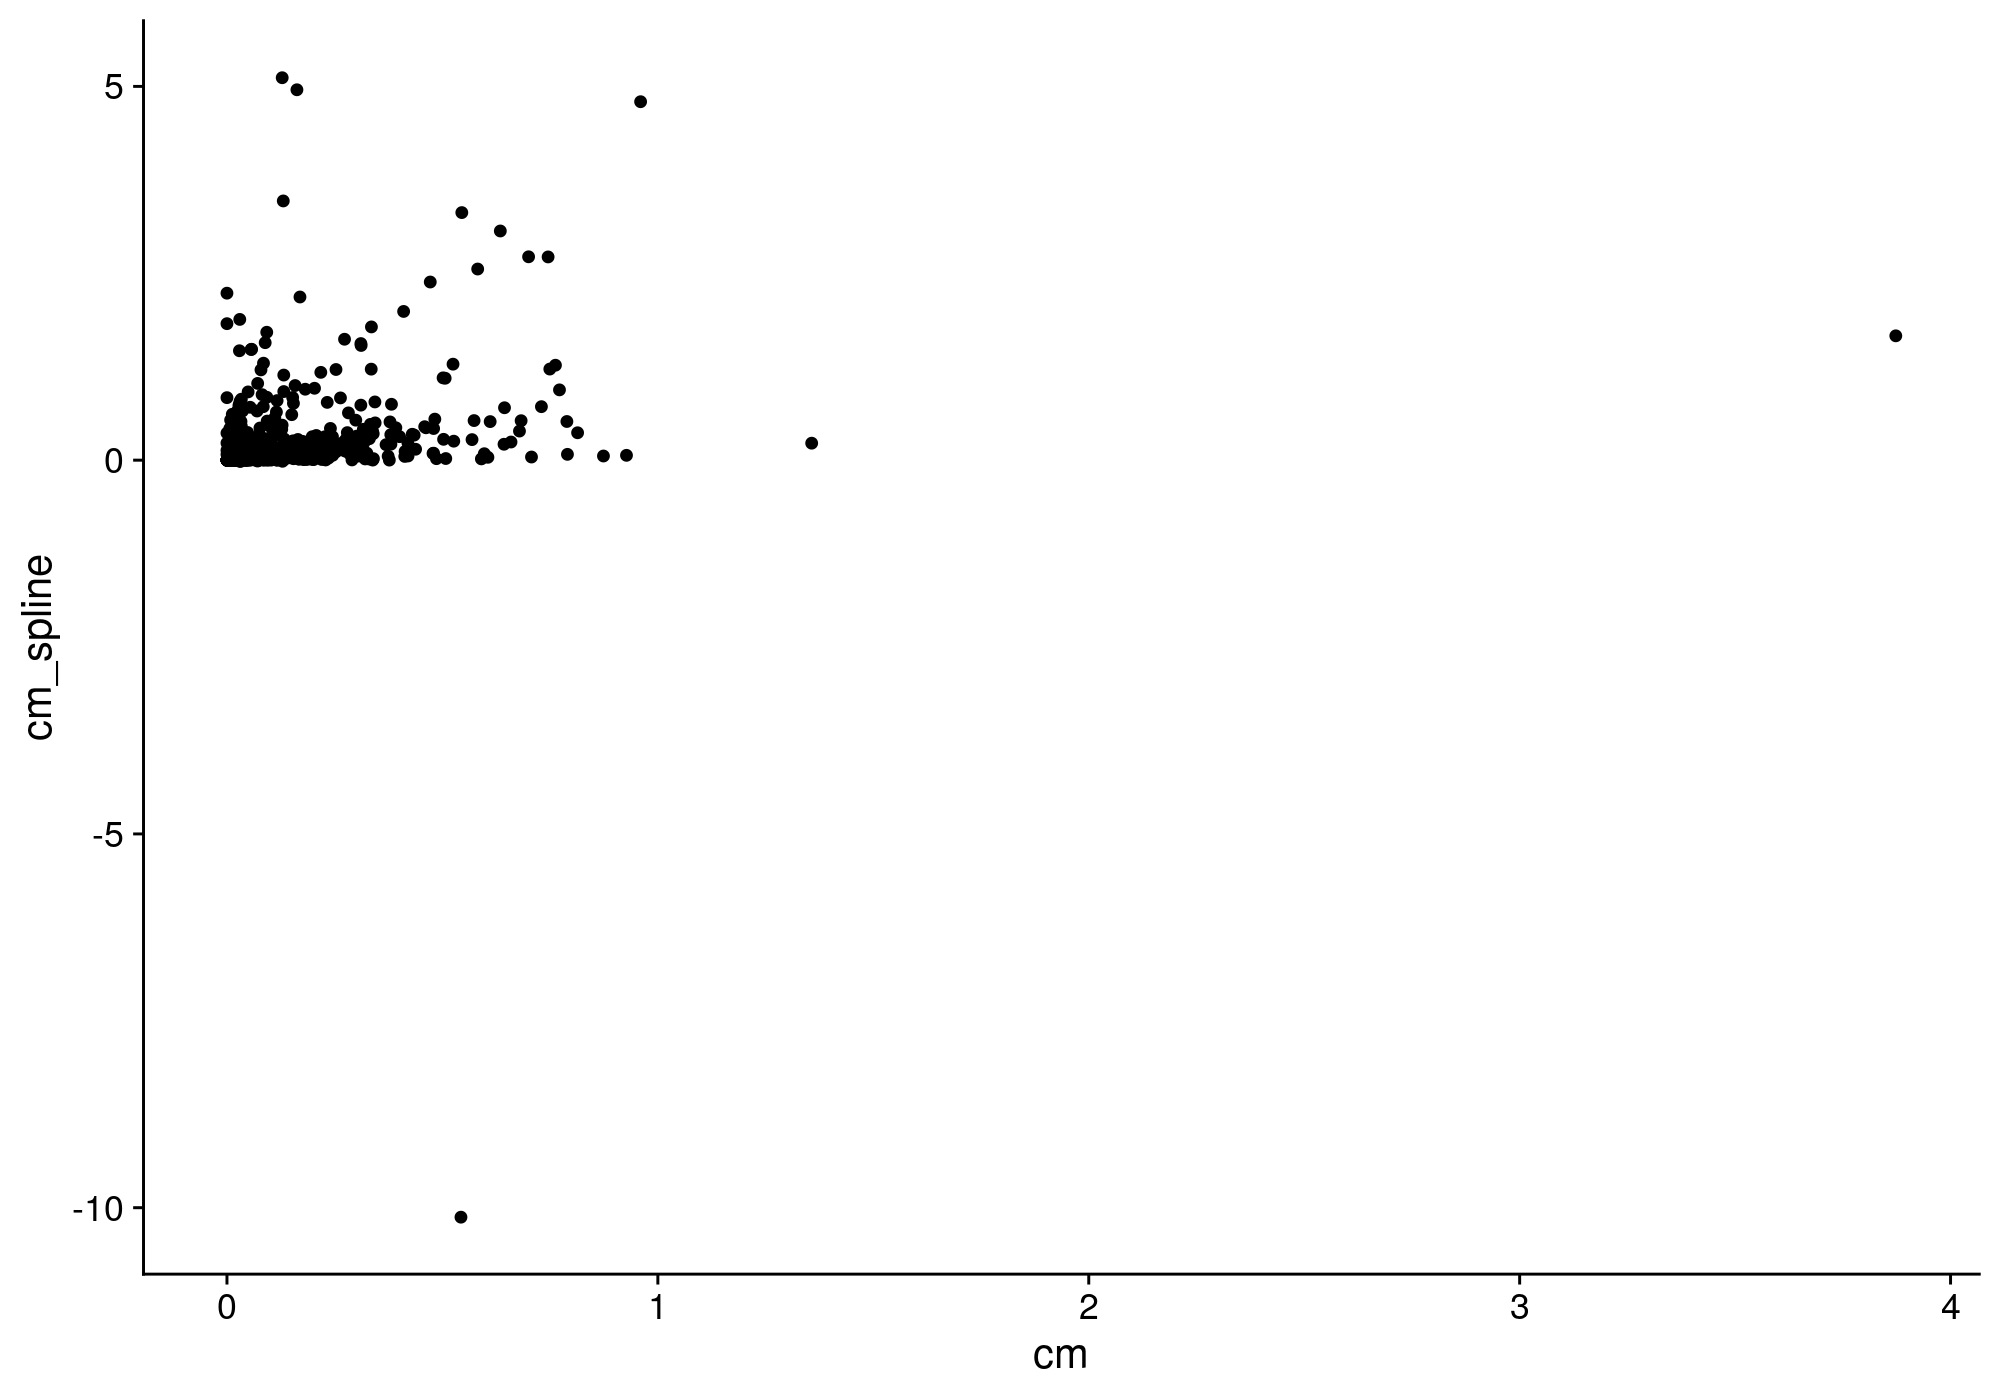

In [53]:
sweep_files <- fs::dir_ls("../data/rdmc/sweep_freq/")

chr <- str_split((str_split(sweep_files, "sweep--", simplify = TRUE)[,2]), "--", simplify = TRUE)[,1]
starts <- as.numeric(str_split((str_split(sweep_files, "start", simplify = TRUE)[,2]), "_", simplify = TRUE)[,1])
ends <- as.numeric(str_split((str_split(sweep_files, "end", simplify = TRUE)[,2]), "_", simplify = TRUE)[,1])

position_df <- tibble(chr = chr, start = starts, end = ends) %>% 
    rowwise() %>% 
    mutate(
        cm = get_cm(gen_map_all_chr, chr, start, end),
        cm_spline = get_cm_spline(spline_models, chr, start, end),
    )

filter(position_df, cm ==0)
filter(position_df, is.na(cm))

print("here")
filter(gen_map_all_chr, chr == "chr8", pos >=84178, pos<=400198)


position_df %>% 
    drop_na() %>% 
    ggplot(aes(cm, cm_spline)) +
    geom_point()

[1]     1714 11022542

0%         10%         20%         30%         40%         50% 
     0.0000    703.0977   1962.6281   3916.8987   6370.6632  10447.8537 
        60%         70%         80%         90%        100% 
 15647.9063  22599.4145  34273.4901  61572.1671 968235.7626

[1] "here"


[1] 250000

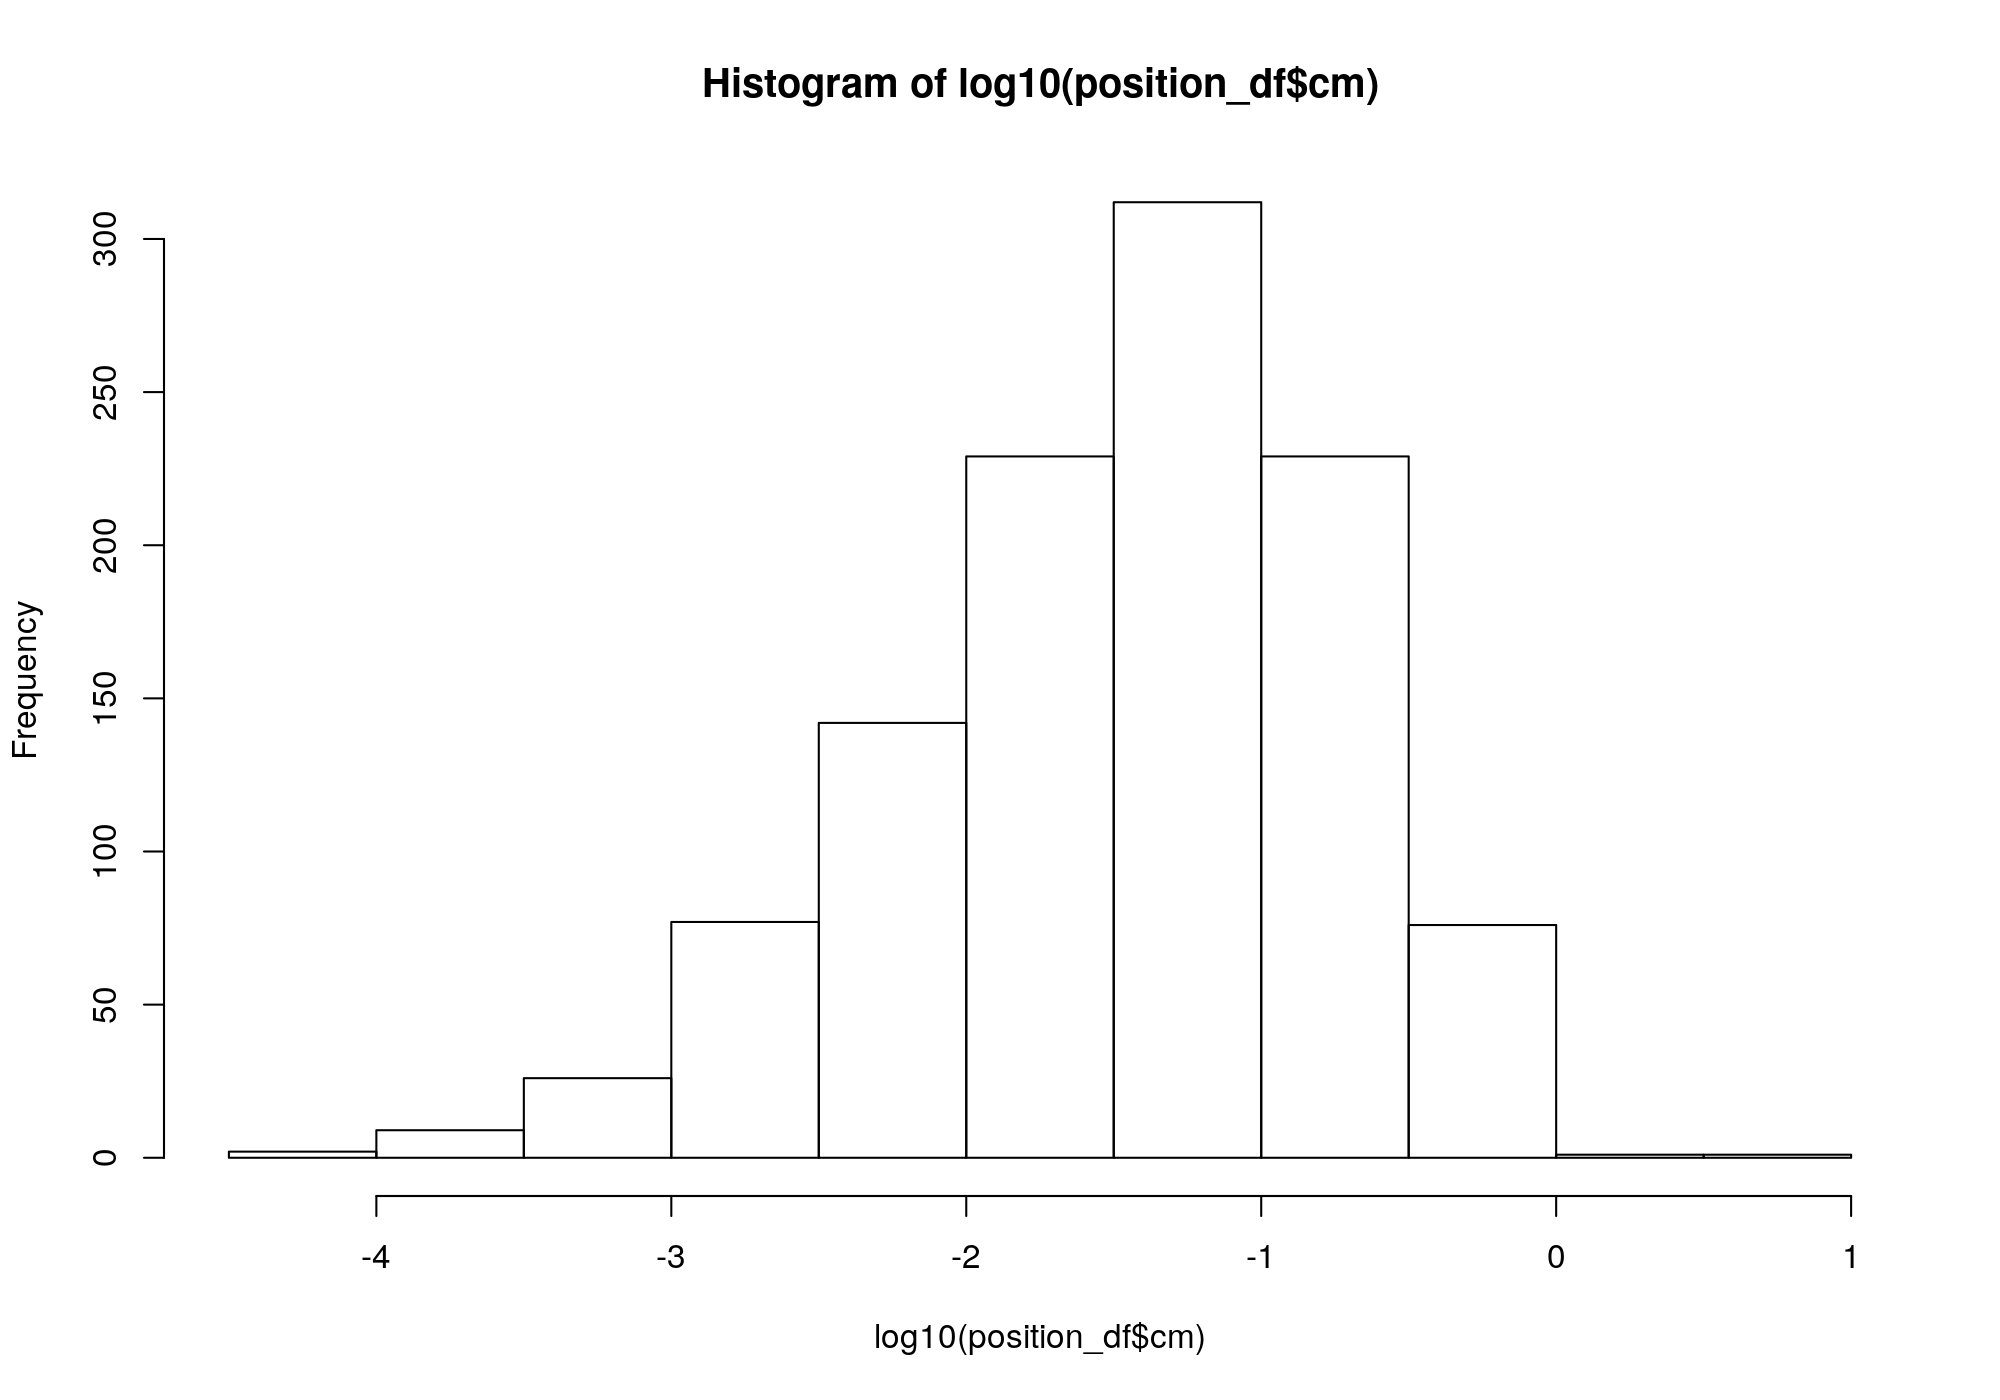

In [66]:
range(position_df$end - position_df$start)

hist(log10(position_df$cm))

q99_cm <- quantile(position_df$cm, 0.5)
mx_snps <- 10000
snp_K <- mx_snps/q99_cm
snp_K  <- 250000
quantile(position_df$cm * snp_K, seq(0,1, length.out = 11))

print("here")
snp_K



#quantile(position_df$cm * 350000, seq(0,1, length.out = 11))

`geom_smooth()` using formula 'y ~ x'



,fit,lwr,upr
1,143072.9,13699.79,1494174


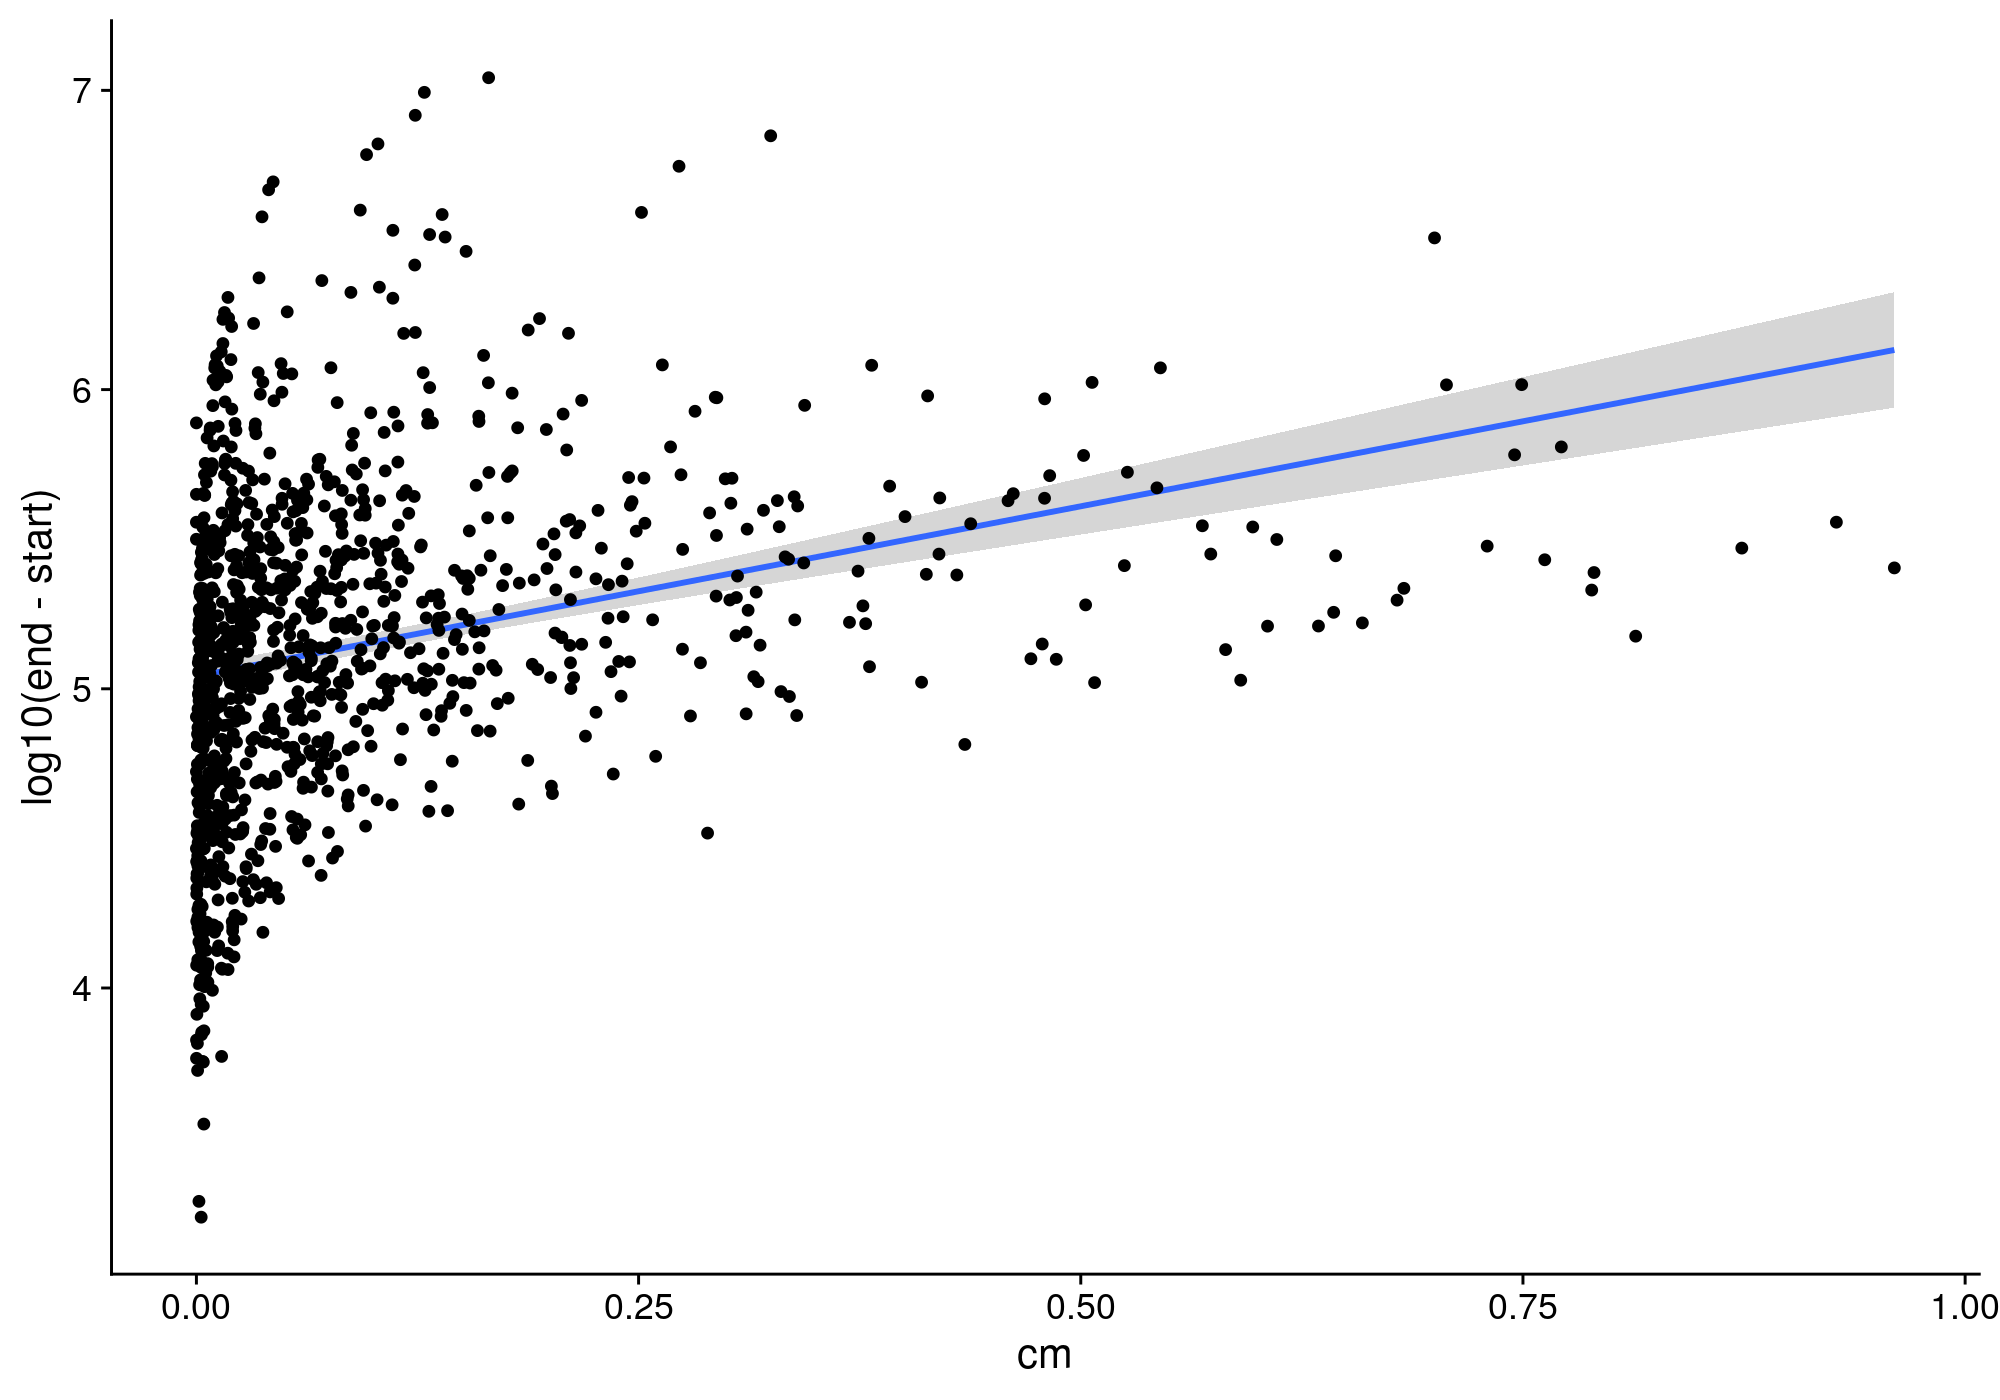

In [48]:
position_df %>% 
    filter(cm < 1) %>% 
    ggplot(aes(cm, log10(end - start))) +
    geom_smooth(method = "lm") +
    geom_point()


10^predict(lm(log10(end - start) ~ cm, data = filter(position_df, cm<1)), newdata = data.frame(cm = .1), interval = "prediction")